In [1]:
# To run: Install gym, numpy, matplotlib and run the following cells
import gym

# Taxi problem

In [2]:
# Import taxi environment
env = gym.make("Taxi-v3").env
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
# State space size
env.action_space

Discrete(6)

In [4]:
# Observation space size
env.observation_space

Discrete(500)

In [5]:
# Show possible reward at state 328
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

In [6]:
# Random policy
env.s = 328
epochs = 0
penalties, reward = 0, 0
done = False
while not done:
    # Get random action
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    if reward == -10:
        penalties += 1
    epochs += 1
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 3354
Penalties incurred: 1129


In [7]:
# Create Q table
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [8]:
record_evolution_taxi = []

In [9]:
%%time
import random

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties = 0, 0
    total_reward = 0
    done = False
    
    # Until dropoff passenger
    while not done:
        # Explore using epsilon
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() 
        else:
            action = np.argmax(q_table[state]) 
        
        # Apply action
        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        # Update Q table        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value
        
        # Record number of penalties
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        total_reward += reward
    
    # Record for comparision with Cart pole
    record_evolution_taxi.append((epochs, penalties, total_reward))
    if i % 10000 == 0:
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 10000
Episode: 20000
Episode: 30000
Episode: 40000
Episode: 50000
Episode: 60000
Episode: 70000
Episode: 80000
Episode: 90000
Episode: 100000
Training finished.

CPU times: user 28.9 s, sys: 1.03 s, total: 29.9 s
Wall time: 28.4 s


In [10]:
# Check probabilities of decisions at state 328
q_table[328]

array([ -2.40931243,  -2.27325184,  -2.40834891,  -2.36065763,
       -10.50927443, -10.91880374])

In [11]:
# Evaluate agent's performance after Q-learning
total_epochs, total_penalties, total_reward = 0, 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    sum_allmove_reward = 0
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1
        sum_allmove_reward += reward

    total_penalties += penalties
    total_epochs += epochs
    total_reward += sum_allmove_reward/epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")
print(f"Average reward per move: {total_reward / episodes}")

Results after 100 episodes:
Average timesteps per episode: 13.29
Average penalties per episode: 0.0
Average reward per move: 0.6536855032222677


In [12]:
# Evaluate random policy
env.s = 328

total_epochs, total_penalties, total_reward = 0, 0, 0
episodes = 100
for _ in range(episodes):
    epochs = 0
    penalties, reward = 0, 0
    done = False
    sum_allmove_reward = 0

    while not done:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if reward == -10:
            penalties += 1
        epochs += 1
        sum_allmove_reward+=reward
        
    total_penalties += penalties
    total_epochs += epochs
    total_reward += sum_allmove_reward/epochs
    
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")
print(f"Average reward per move: {total_reward / episodes}")

Results after 100 episodes:
Average timesteps per episode: 741.99
Average penalties per episode: 239.05
Average reward per move: -2.516854817935028


# CartPole problem

In [13]:
# Import cart pole environment
env = gym.make("CartPole-v1").env
env.reset()
env.render()

True

In [14]:
# Check observation and state space
env.action_space, env.observation_space

(Discrete(2),
 Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32))

In [15]:
# Create a q table with suitable size
# Note that these constant are from dividing valid value of the cart/pole by the window size (see below)
Observation = [50,50, 50, 50]
q_table = np.random.uniform(low=0, high=1, size=(Observation+[env.action_space.n]))
q_table.shape

(50, 50, 50, 50, 2)

In [18]:
# The window size for clipping value
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

# Util function to turn it discrete
def get_discrete_state(state):
    discrete_state = state/np_array_win_size+ np.array([15,10,1,10])
    return tuple(discrete_state.astype(np.int))


In [21]:
# Example with Q table before learning

total_epochs, total_penalties, total_reward = 0, 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    state = get_discrete_state(state)
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    sum_allmove_reward = 0
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)
        state = get_discrete_state(state)
        epochs += 1
        sum_allmove_reward += reward

    total_penalties += penalties
    total_epochs += epochs
    total_reward += sum_allmove_reward/epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")
print(f"Average reward per move: {total_reward / episodes}")

Results after 100 episodes:
Average timesteps per episode: 26.83
Average penalties per episode: 0.0
Average reward per move: 1.0


<ipython-input-18-987efe39d353>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple(discrete_state.astype(np.int))


In [22]:
record_evolution_cartpole = []

In [23]:
# Training agent
%%time
import random

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

for i in range(1, 100001):
    state = get_discrete_state(env.reset())
    
    epochs, total_reward = 0, 0
    done = False
    
    while not done:
        #  Explore using epsilon
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])
        
        #  Apply action
        next_state, reward, done, info = env.step(action) 
        next_state = get_discrete_state(next_state)
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        #  Update Q table
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        state = next_state
        epochs += 1
        total_reward+=reward
    
    record_evolution_cartpole.append((epochs, total_reward))
    if i % 10000 == 0:
        print(f"Episode: {i}")

print("Training finished.\n")

<ipython-input-18-987efe39d353>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple(discrete_state.astype(np.int))


Episode: 10000
Episode: 20000
Episode: 30000
Episode: 40000
Episode: 50000
Episode: 60000
Episode: 70000
Episode: 80000
Episode: 90000
Episode: 100000
Training finished.

CPU times: user 3min 11s, sys: 19.5 ms, total: 3min 11s
Wall time: 3min 12s


In [27]:
# Evaluate agent's performance after Q-learning

total_epochs, total_penalties, total_reward = 0, 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    state = get_discrete_state(state)
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    sum_allmove_reward = 0
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)
        state = get_discrete_state(state)
        epochs += 1
        sum_allmove_reward += reward

    total_penalties += penalties
    total_epochs += epochs
    total_reward += sum_allmove_reward/epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")
print(f"Average reward per move: {total_reward / episodes}")

Results after 100 episodes:
Average timesteps per episode: 29.4
Average penalties per episode: 0.0
Average reward per move: 1.0


<ipython-input-18-987efe39d353>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple(discrete_state.astype(np.int))


# Comparing Q learning performance in 2 problems

In [28]:
# Get rewards and plot them
reward_taxi = [a[2] for a in record_evolution_taxi]

In [29]:
reward_taxi

[-1667,
 -1105,
 -738,
 -3673,
 -805,
 -1328,
 -611,
 -951,
 -1256,
 -921,
 -1184,
 -542,
 -3325,
 -847,
 -526,
 -683,
 -981,
 -2217,
 -2191,
 -521,
 -1428,
 -450,
 -751,
 -302,
 -799,
 -677,
 -764,
 -476,
 -1259,
 -404,
 -648,
 -830,
 -1103,
 -411,
 -325,
 -603,
 -1188,
 -1493,
 -633,
 -371,
 -1218,
 -396,
 -795,
 -1056,
 -300,
 -541,
 -226,
 -289,
 -358,
 -251,
 -105,
 -416,
 -547,
 -371,
 -344,
 -159,
 -845,
 -324,
 -636,
 -369,
 -203,
 -284,
 -784,
 -291,
 -4,
 -224,
 -302,
 -726,
 -590,
 -635,
 -704,
 -446,
 -575,
 -264,
 -615,
 -634,
 -102,
 -198,
 -139,
 -340,
 -39,
 -379,
 -554,
 -432,
 -264,
 -661,
 -439,
 -279,
 -96,
 -204,
 -547,
 -407,
 -363,
 -332,
 -363,
 -603,
 -415,
 -173,
 -80,
 -398,
 -358,
 -701,
 -291,
 -393,
 -464,
 -293,
 -238,
 -112,
 -363,
 -310,
 -258,
 -370,
 -209,
 -389,
 -147,
 -212,
 -307,
 -557,
 -221,
 -399,
 -211,
 -347,
 -280,
 -92,
 -106,
 -327,
 -409,
 -330,
 -221,
 -290,
 -326,
 -102,
 -30,
 -424,
 -313,
 -298,
 -31,
 -170,
 -72,
 -411,
 -29,
 -287,


In [30]:
reward_cartpole = [a[1] for a in record_evolution_cartpole]

In [31]:
reward_cartpole

[45.0,
 17.0,
 24.0,
 51.0,
 26.0,
 17.0,
 26.0,
 22.0,
 10.0,
 42.0,
 13.0,
 16.0,
 51.0,
 15.0,
 24.0,
 23.0,
 16.0,
 83.0,
 20.0,
 13.0,
 15.0,
 28.0,
 39.0,
 21.0,
 21.0,
 30.0,
 12.0,
 16.0,
 16.0,
 27.0,
 11.0,
 19.0,
 29.0,
 17.0,
 11.0,
 28.0,
 36.0,
 12.0,
 17.0,
 14.0,
 13.0,
 14.0,
 59.0,
 18.0,
 46.0,
 13.0,
 20.0,
 10.0,
 12.0,
 12.0,
 21.0,
 22.0,
 26.0,
 42.0,
 18.0,
 18.0,
 21.0,
 22.0,
 18.0,
 22.0,
 17.0,
 13.0,
 27.0,
 11.0,
 14.0,
 22.0,
 15.0,
 30.0,
 36.0,
 29.0,
 22.0,
 18.0,
 31.0,
 26.0,
 17.0,
 51.0,
 36.0,
 14.0,
 47.0,
 15.0,
 15.0,
 15.0,
 33.0,
 12.0,
 24.0,
 14.0,
 45.0,
 40.0,
 25.0,
 21.0,
 38.0,
 15.0,
 27.0,
 100.0,
 15.0,
 15.0,
 37.0,
 28.0,
 20.0,
 97.0,
 32.0,
 10.0,
 33.0,
 65.0,
 22.0,
 10.0,
 13.0,
 60.0,
 63.0,
 10.0,
 16.0,
 16.0,
 12.0,
 14.0,
 16.0,
 16.0,
 13.0,
 28.0,
 15.0,
 12.0,
 46.0,
 14.0,
 18.0,
 16.0,
 19.0,
 22.0,
 26.0,
 21.0,
 32.0,
 15.0,
 24.0,
 19.0,
 17.0,
 25.0,
 14.0,
 12.0,
 37.0,
 17.0,
 24.0,
 14.0,
 18.0,
 13.0,
 15.0

In [32]:
import matplotlib.pyplot as plt

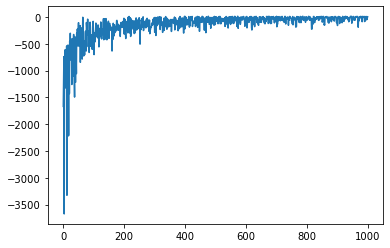

In [33]:
plt.plot(reward_taxi[:1000])

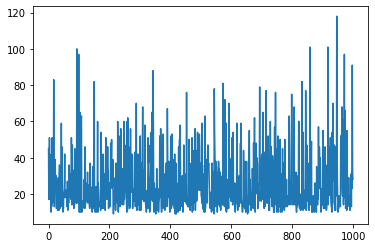

In [34]:
plt.plot(reward_cartpole[:1000])

In [35]:
# Get episode length and plot them
episode_length_taxi = [a[0] for a in record_evolution_taxi]
episode_length_cartpole = [a[0] for a in record_evolution_cartpole]

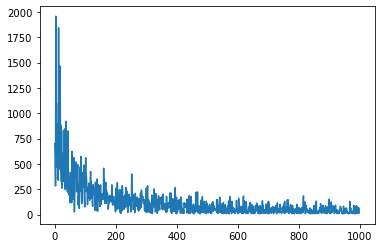

In [36]:
plt.plot(episode_length_taxi[:1000])

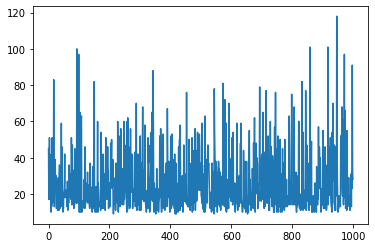

In [37]:
plt.plot(episode_length_cartpole[:1000])